<a href="https://www.kaggle.com/code/kmljts/lightclearnet?scriptVersionId=180581441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import os
# for root, folders, filenames in os.walk('/kaggle/input'):
#     print(root, folders)

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from PIL import Image
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import random

from tqdm.auto import tqdm

In [3]:
input_dir = '/kaggle/input/reside-6k/RESIDE-6K'
dataset_path = os.path.join(input_dir, 'train')
test_dataset_path = os.path.join(input_dir, 'test')

output_dir = '/kaggle/working'
model_save_path = os.path.join(output_dir, 'models')
result_save_path = os.path.join(output_dir, 'results')
plot_save_path = os.path.join(output_dir, 'plots')

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(result_save_path, exist_ok=True)
os.makedirs(plot_save_path, exist_ok=True)

dataset_path, test_dataset_path, model_save_path, result_save_path, plot_save_path

('/kaggle/input/reside-6k/RESIDE-6K/train',
 '/kaggle/input/reside-6k/RESIDE-6K/test',
 '/kaggle/working/models',
 '/kaggle/working/results',
 '/kaggle/working/plots')

In [4]:
# import shutil
# shutil.rmtree(output_dir)

In [5]:
# sorted(os.listdir(model_save_path)), sorted(os.listdir(result_save_path)), sorted(os.listdir(plot_save_path))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [7]:
torch.cuda.empty_cache()

In [8]:
BATCH_SIZE = 16
TEST_BATCH_SIZE = 1

LR = 1e-3
EPOCHS = 10
NORMALIZE = False

In [9]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * self.std + self.mean
    
class Identity:
    def __call__(self, tensor):
        return tensor

img_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) if NORMALIZE else Identity()
])

tensor_to_img = transforms.Compose([
    UnNormalize(0.5, 0.5) if NORMALIZE else Identity(),
    transforms.ToPILImage()
])

In [10]:
def current_datetime():
    cur_datetime = datetime.now() + timedelta(hours=5, minutes=30) # IST
    return cur_datetime.strftime("%Y-%m-%d_%H-%M-%S")

def unique_file_namer(model_name, n_epochs=EPOCHS, learning_rate=LR, batch_size=BATCH_SIZE):
    return f'{current_datetime()}_{model_name}_{n_epochs}_{learning_rate:.2e}_{batch_size}'

In [11]:
criterion = nn.L1Loss()
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

def visualize_pair(image1, image2, gap=20):
    image1 = tensor_to_img(image1) if isinstance(image1, torch.Tensor) else image1
    image2 = tensor_to_img(image2) if isinstance(image2, torch.Tensor) else image2

    new_image = Image.new('RGB', (image1.width + gap + image2.width, max(image1.height, image2.height)), color='black')
    new_image.paste(image1, (0, 0))
    new_image.paste(image2, (image1.width + gap, 0))

    return new_image

def visualize_random_pair_target(dataset):
    random_idx = random.randrange(len(dataset))
    print(f'Index: {random_idx}')

    return dataset.visualize_pair(random_idx)

def visualize_random_pair_pred(dataset, model, visualize_target=False, normalize=False):
    random_idx = random.randrange(len(dataset))
    print(dataset.inputs_folder + '/' + dataset.inputs_file_list[random_idx])

    input, target = [tensor.unsqueeze(0) for tensor in dataset[random_idx]]
    print(f'Image size: {[*input.shape]}')

    model.eval()
    with torch.inference_mode():
        pred = model(input)

    loss = criterion(pred, target).item()
    psnr = psnr_metric(pred, target).item()
    ssim = ssim_metric(pred, target).item()

    print(f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%')

    if visualize_target:
        return visualize_pair(visualize_pair(input.squeeze(), pred.squeeze()), target.squeeze())
    return visualize_pair(input.squeeze(), pred.squeeze())

In [12]:
class HazyToClearDataset(Dataset):
    def __init__(self, root_loc, transform=None):
        self.root_loc = root_loc
        self.transform = transform

        self.inputs_folder = f'{self.root_loc}/hazy'
        self.targets_folder = f'{self.root_loc}/GT'
        self.inputs_file_list = sorted(os.listdir(self.inputs_folder))
        self.targets_file_list = sorted(os.listdir(self.targets_folder))

    def __len__(self):
        return len(self.inputs_file_list)

    def __getitem__(self, idx):
        input_loc = os.path.join(self.inputs_folder, self.inputs_file_list[idx])
        target_loc = os.path.join(self.targets_folder, self.targets_file_list[idx])

        input = Image.open(input_loc)
        target = Image.open(target_loc)

        if self.transform:
            input = self.transform(input).to(device)
            target = self.transform(target).to(device)

        return input, target

    def visualize_pair(self, idx):
        print(f'Input Image: {self.inputs_folder}/{self.inputs_file_list[idx]}')
        print(f'Target Image: {self.targets_folder}/{self.targets_file_list[idx]}')

        return visualize_pair(*self[idx])
    
    def index(self, image_name):
        return self.inputs_file_list.index(image_name)

In [13]:
dataset = HazyToClearDataset(dataset_path, transform=img_to_tensor)
test_dataset = HazyToClearDataset(test_dataset_path, transform=img_to_tensor)

len(dataset), random.choice(dataset)

(6000,
 (tensor([[[0.4745, 0.4784, 0.4824,  ..., 0.4745, 0.4745, 0.4627],
           [0.4745, 0.4784, 0.4863,  ..., 0.4706, 0.4706, 0.4667],
           [0.4667, 0.4784, 0.4902,  ..., 0.4667, 0.4706, 0.4706],
           ...,
           [0.7373, 0.7412, 0.7529,  ..., 0.4824, 0.5843, 0.5882],
           [0.7373, 0.7490, 0.6980,  ..., 0.5098, 0.5725, 0.5765],
           [0.7059, 0.7647, 0.7647,  ..., 0.5765, 0.6078, 0.6078]],
  
          [[0.6431, 0.6471, 0.6510,  ..., 0.6392, 0.6392, 0.6275],
           [0.6431, 0.6471, 0.6549,  ..., 0.6353, 0.6353, 0.6314],
           [0.6431, 0.6549, 0.6549,  ..., 0.6314, 0.6353, 0.6353],
           ...,
           [0.7608, 0.7725, 0.7843,  ..., 0.5333, 0.6471, 0.6510],
           [0.7686, 0.7804, 0.7255,  ..., 0.5608, 0.6353, 0.6392],
           [0.7373, 0.7961, 0.8039,  ..., 0.6275, 0.6706, 0.6706]],
  
          [[0.8588, 0.8627, 0.8667,  ..., 0.8667, 0.8667, 0.8549],
           [0.8588, 0.8627, 0.8706,  ..., 0.8627, 0.8627, 0.8588],
           [0.8

Index: 1748
Input Image: /kaggle/input/reside-6k/RESIDE-6K/train/hazy/2572.jpg
Target Image: /kaggle/input/reside-6k/RESIDE-6K/train/GT/2572.jpg


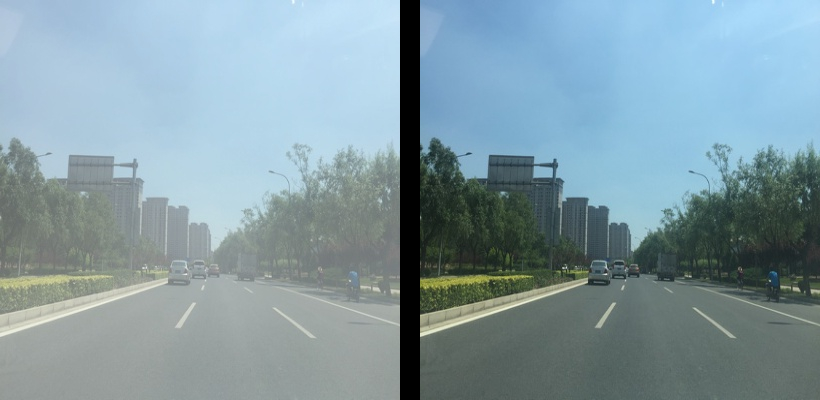

In [14]:
visualize_random_pair_target(dataset)

Index: 578
Input Image: /kaggle/input/reside-6k/RESIDE-6K/test/hazy/1421_4.png
Target Image: /kaggle/input/reside-6k/RESIDE-6K/test/GT/1421_4.png


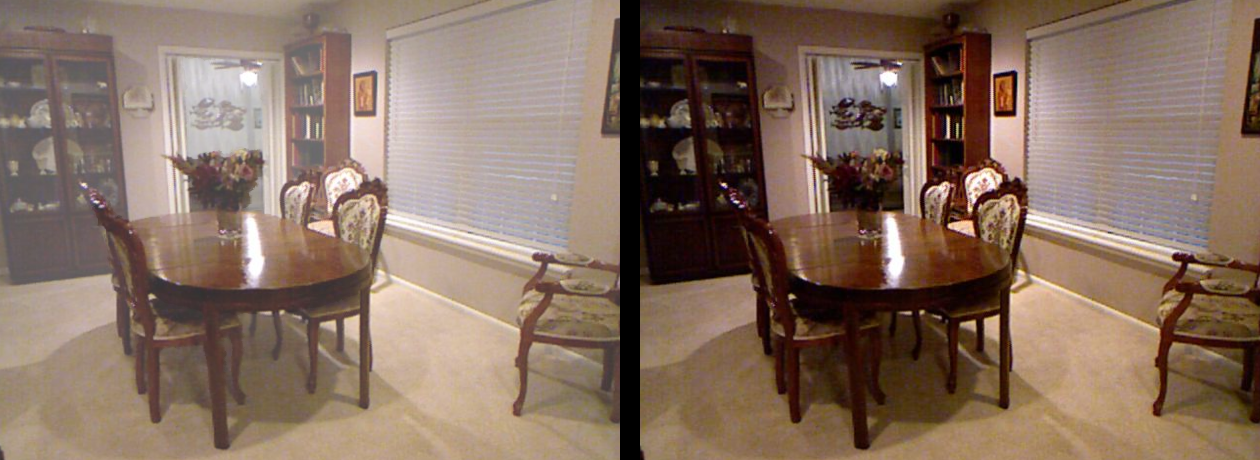

In [15]:
visualize_random_pair_target(test_dataset)

Input Image: /kaggle/input/reside-6k/RESIDE-6K/train/hazy/166.jpg
Target Image: /kaggle/input/reside-6k/RESIDE-6K/train/GT/166.jpg


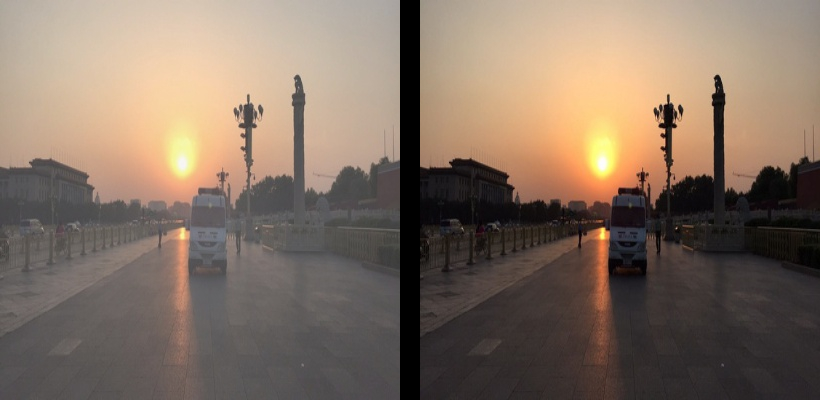

In [16]:
dataset.visualize_pair(734)
# dataset.index('407.jpg')

In [17]:
train_dataset, val_dataset = random_split(dataset, [5500, 500])

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(344, 32, 1000)

In [19]:
class LightClearNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(128)

        # Decoder
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        skip1 = x
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        skip2 = x
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))

        # Decoder
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = x + skip2
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = x + skip1
        x = F.sigmoid(self.dec_conv3(x))

        return x

In [20]:
model = LightClearNet().to(device)

model

LightClearNet(
  (enc_conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dec_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dec_conv3): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [21]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(dataset)[0].unsqueeze(0))
pred

tensor([[[[0.4704, 0.4879, 0.4838,  ..., 0.4761, 0.4823, 0.5085],
          [0.4469, 0.4741, 0.4729,  ..., 0.4539, 0.4595, 0.5071],
          [0.4411, 0.4701, 0.4702,  ..., 0.4511, 0.4561, 0.5021],
          ...,
          [0.4538, 0.4781, 0.4768,  ..., 0.4885, 0.4826, 0.5045],
          [0.4501, 0.4765, 0.4708,  ..., 0.4768, 0.4890, 0.5058],
          [0.4604, 0.4803, 0.4808,  ..., 0.4834, 0.4882, 0.5079]],

         [[0.5169, 0.5191, 0.5175,  ..., 0.5225, 0.5098, 0.4829],
          [0.5314, 0.5160, 0.5100,  ..., 0.5124, 0.4961, 0.4589],
          [0.5377, 0.5097, 0.5056,  ..., 0.5111, 0.4955, 0.4557],
          ...,
          [0.5290, 0.5148, 0.5111,  ..., 0.5180, 0.5105, 0.4704],
          [0.5294, 0.5079, 0.5089,  ..., 0.5015, 0.4955, 0.4667],
          [0.5134, 0.4970, 0.4938,  ..., 0.4797, 0.4714, 0.4549]],

         [[0.4674, 0.4766, 0.4801,  ..., 0.4830, 0.4765, 0.4924],
          [0.4794, 0.4899, 0.4923,  ..., 0.4942, 0.4784, 0.4868],
          [0.4777, 0.4913, 0.4903,  ..., 0

In [22]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(test_dataset)[0].unsqueeze(0))
pred

tensor([[[[0.4610, 0.4804, 0.4773,  ..., 0.4788, 0.4848, 0.5031],
          [0.4311, 0.4605, 0.4612,  ..., 0.4711, 0.4779, 0.5082],
          [0.4266, 0.4625, 0.4621,  ..., 0.4719, 0.4760, 0.5047],
          ...,
          [0.4717, 0.4901, 0.4888,  ..., 0.4656, 0.4718, 0.5109],
          [0.4699, 0.4863, 0.4832,  ..., 0.4613, 0.4660, 0.5063],
          [0.4725, 0.4871, 0.4869,  ..., 0.4776, 0.4770, 0.5054]],

         [[0.5297, 0.5284, 0.5272,  ..., 0.5209, 0.5109, 0.4884],
          [0.5531, 0.5292, 0.5182,  ..., 0.5134, 0.4978, 0.4656],
          [0.5559, 0.5214, 0.5140,  ..., 0.5107, 0.4961, 0.4614],
          ...,
          [0.5136, 0.5081, 0.5070,  ..., 0.5147, 0.4936, 0.4517],
          [0.5115, 0.5043, 0.5058,  ..., 0.5107, 0.4950, 0.4497],
          [0.5011, 0.4956, 0.4943,  ..., 0.4881, 0.4792, 0.4475]],

         [[0.4585, 0.4670, 0.4712,  ..., 0.4747, 0.4740, 0.4874],
          [0.4747, 0.4853, 0.4869,  ..., 0.4904, 0.4820, 0.4847],
          [0.4735, 0.4876, 0.4887,  ..., 0

/kaggle/input/reside-6k/RESIDE-6K/train/hazy/2050.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.2706 | PSNR: 10.6723 | SSIM: 62.13%


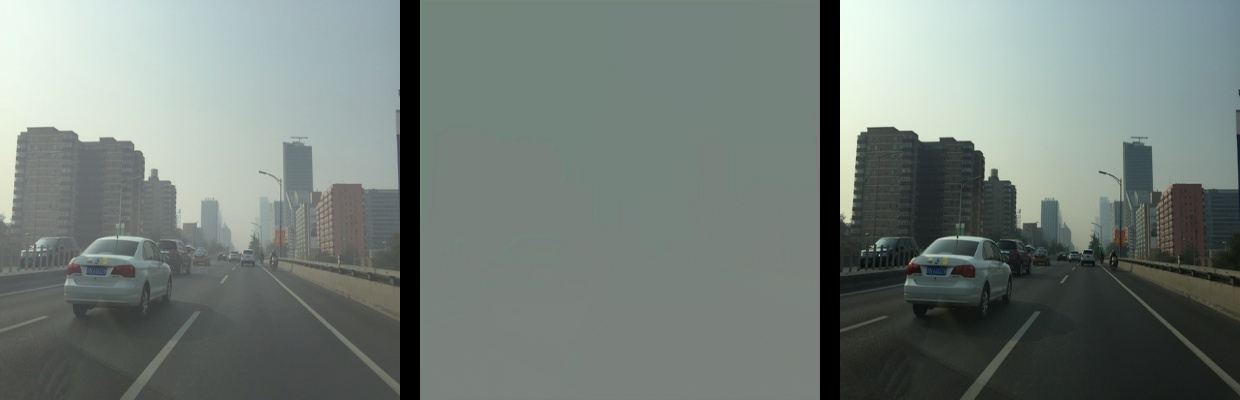

In [23]:
visualize_random_pair_pred(dataset, model, visualize_target=True, normalize=False)

In [24]:
criterion = nn.L1Loss()
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [25]:
train_losses = []
val_losses = []
psnrs = []
ssims = []

In [26]:
train_losses, val_losses, psnrs, ssims

([], [], [], [])

In [27]:
loss = 0
psnr = 0
ssim = 0

model.eval()
with torch.inference_mode():
    for X, y in tqdm(val_dataloader):
        pred = model(X)

        loss += criterion(pred, y).item()
        psnr += psnr_metric(pred, y).item()
        ssim += ssim_metric(pred, y).item()

loss /= len(val_dataloader)
psnr /= len(val_dataloader)
ssim /= len(val_dataloader)

# train_losses.append(loss)
# val_losses.append(loss)
# psnrs.append(psnr)
# ssims.append(ssim)
print(f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%')

best_ssim = ssim
best_ssim_epoch = 0

  0%|          | 0/32 [00:00<?, ?it/s]

L1 Loss: 0.2485 | PSNR: 10.8046 | SSIM: 45.62%


In [28]:
# %%timeit -n 1 -r 1

prev_size = len(train_losses)

for epoch in tqdm(range(EPOCHS)):
    train_loss = 0
    val_loss = 0
    psnr = 0
    ssim = 0

    model.train()
    for X, y in tqdm(train_dataloader):
        pred = model(X) 
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_dataloader):
            pred = model(X)

            val_loss += criterion(pred, y).item()
            psnr += psnr_metric(pred, y).item()
            ssim += ssim_metric(pred, y).item()

    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    psnr /= len(val_dataloader)
    ssim /= len(val_dataloader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    psnrs.append(psnr)
    ssims.append(ssim)
    print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size - 1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim:.4f}')
    
    if ssim > best_ssim:
        model_name = f'{unique_file_namer(model.__class__.__name__)}.pth'
        model_path = os.path.join(model_save_path, model_name)
        torch.save(model.state_dict(), model_path)
        print('>>> Model saved!')
        print(model_path)

        best_ssim = ssim
        best_ssim_epoch = epoch + prev_size
    
    # reloading the best model yet every 5 epochs
    if epoch % 5 == 4:
        best_model_name = sorted(os.listdir(model_save_path))[-1]
        best_model_path = os.path.join(model_save_path, best_model_name)
        print('Reloaded:', best_model_path)

        model.load_state_dict(torch.load(best_model_path))
        
    print('\n' + '*' * 80 + '\n')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0/9 | Train Loss: 0.0987 | Val Loss: 0.0978 | PSNR: 17.5660 | SSIM: 0.8088
>>> Model saved!
/kaggle/working/models/2024-05-30_15-13-15_LightClearNet_10_1.00e-03_16.pth

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1/9 | Train Loss: 0.0922 | Val Loss: 0.0967 | PSNR: 17.4960 | SSIM: 0.8105
>>> Model saved!
/kaggle/working/models/2024-05-30_15-16-17_LightClearNet_10_1.00e-03_16.pth

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2/9 | Train Loss: 0.0895 | Val Loss: 0.0961 | PSNR: 17.2646 | SSIM: 0.8154
>>> Model saved!
/kaggle/working/models/2024-05-30_15-19-20_LightClearNet_10_1.00e-03_16.pth

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3/9 | Train Loss: 0.0886 | Val Loss: 0.0911 | PSNR: 18.1606 | SSIM: 0.7998

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4/9 | Train Loss: 0.0878 | Val Loss: 0.0962 | PSNR: 17.4705 | SSIM: 0.8063
Reloaded: /kaggle/working/models/2024-05-30_15-19-20_LightClearNet_10_1.00e-03_16.pth

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5/9 | Train Loss: 0.0887 | Val Loss: 0.0986 | PSNR: 17.3952 | SSIM: 0.7718

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6/9 | Train Loss: 0.0883 | Val Loss: 0.0871 | PSNR: 18.3850 | SSIM: 0.8042

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7/9 | Train Loss: 0.0866 | Val Loss: 0.0950 | PSNR: 17.7770 | SSIM: 0.8082

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8/9 | Train Loss: 0.0858 | Val Loss: 0.0939 | PSNR: 18.1178 | SSIM: 0.7829

********************************************************************************



  0%|          | 0/344 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9/9 | Train Loss: 0.0857 | Val Loss: 0.0901 | PSNR: 17.6993 | SSIM: 0.7937
Reloaded: /kaggle/working/models/2024-05-30_15-19-20_LightClearNet_10_1.00e-03_16.pth

********************************************************************************



/tmp/ipykernel_24/486262.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


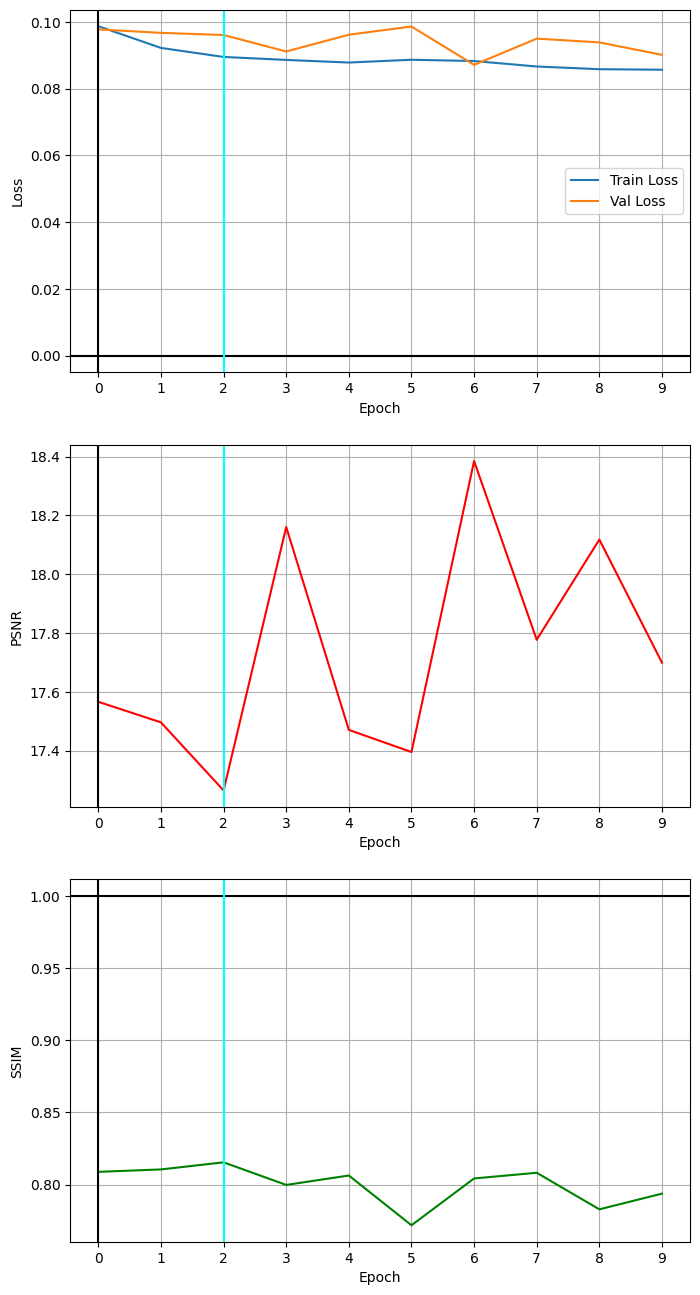

In [29]:
plt.figure(figsize=(8, 16))
plt.title(f'{model.__class__.__name__} Training/Validation Plot')
plt.axis('off')
# plt.subplots_adjust(bottom=-0.3)

# ========== (1) ==========

plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.axvline(best_ssim_epoch, color='cyan')
plt.legend(loc='best')
# plt.ylim(-0.05, 1)

# ========== (2) ==========

plt.subplot(3, 1, 2)
plt.plot(psnrs, label='PSNR', c='red')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axvline(0, color='black')
plt.axvline(best_ssim_epoch, color='cyan')

# ========== (3) ==========

plt.subplot(3, 1, 3)
plt.plot(ssims, label='SSIM', c='green')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
if len(train_losses) <= 20:
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.axhline(1, color='black')
plt.axvline(0, color='black')
plt.axvline(best_ssim_epoch, color='cyan')

plot_file_name = f'{unique_file_namer(model.__class__.__name__)}.png'
plt.savefig(os.path.join(plot_save_path, plot_file_name), bbox_inches='tight')

plt.show()

In [30]:
best_model_name = sorted(os.listdir(model_save_path))[-1]
best_model_path = os.path.join(model_save_path, best_model_name)
print(best_model_path)

model.load_state_dict(torch.load(best_model_path))

/kaggle/working/models/2024-05-30_15-19-20_LightClearNet_10_1.00e-03_16.pth


<All keys matched successfully>

In [31]:
# %%timeit -n 1 -r 1

loss = 0
psnr = 0
ssim = 0

model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        preds = model(X)

        loss += criterion(preds, y).item()
        psnr += psnr_metric(preds, y).item()
        ssim += ssim_metric(preds, y).item()

loss /= len(test_dataloader)
psnr /= len(test_dataloader)
ssim /= len(test_dataloader)

result = f'L1 Loss: {loss:.4f} | PSNR: {psnr:.4f} | SSIM: {ssim * 100:.2f}%'
print(result)

result_file_name = f'{unique_file_namer(model.__class__.__name__)}.txt'
with open(os.path.join(result_save_path, result_file_name), 'w') as f:
    f.write(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

L1 Loss: 0.0835 | PSNR: 20.9672 | SSIM: 85.45%


/kaggle/input/reside-6k/RESIDE-6K/train/hazy/2463.jpg
Image size: [1, 3, 400, 400]
L1 Loss: 0.0253 | PSNR: 29.6285 | SSIM: 95.66%


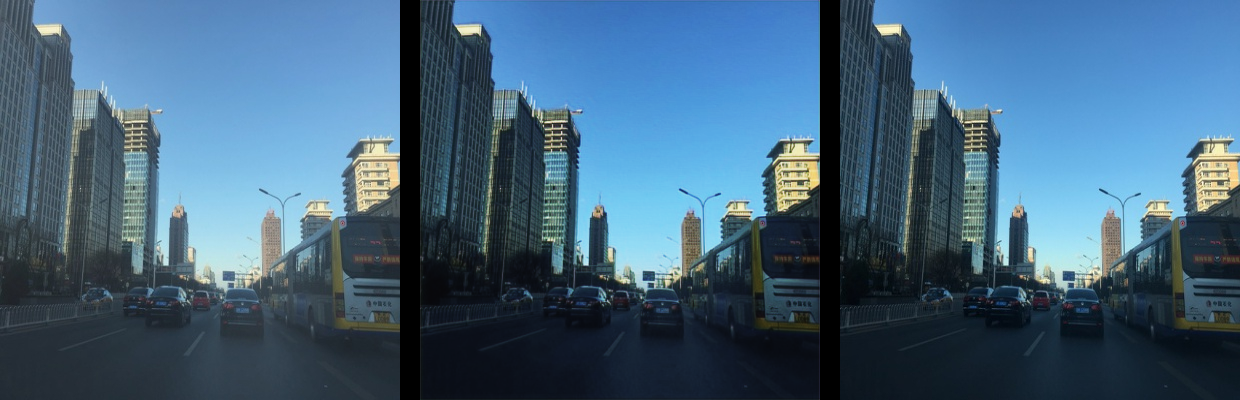

In [32]:
visualize_random_pair_pred(dataset, model, visualize_target=True)

/kaggle/input/reside-6k/RESIDE-6K/test/hazy/1446_6.png
Image size: [1, 3, 460, 620]
L1 Loss: 0.1128 | PSNR: 16.9647 | SSIM: 79.36%


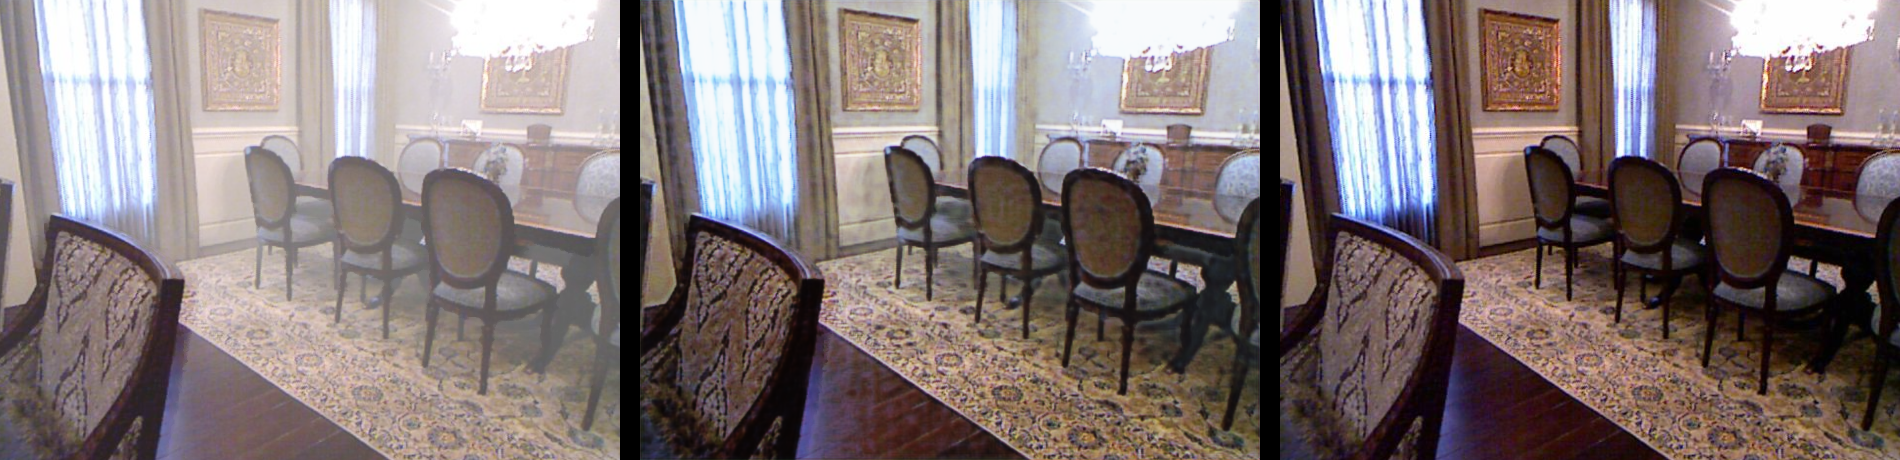

In [33]:
visualize_random_pair_pred(test_dataset, model, visualize_target=True)